In [1]:
import pandas as pd
import numpy as np
import time
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import numpy.random as rng
import re
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

caminho_do_projeto = r'C:\Users\kmenezes\OneDrive - unb.br\tcc_organizacao'

if caminho_do_projeto not in sys.path:
    sys.path.insert(0, caminho_do_projeto)
from projeto_aplicado.modelos.otimizador_pli import OtimizadorPLI
from projeto_aplicado.modelos.otimizador_aco import OtimizadorACO
from projeto_aplicado.modelos.otimizador_ag import OtimizadorAG
from projeto_aplicado.modelos.otimizador_base import Otimizador
from projeto_aplicado.modelos.analisador import AnalisadorDeSolucao
base = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\dados"
grafs_dir = r"C:\\Users\\kmenezes\\OneDrive - unb.br\\tcc_organizacao\\graficos"

# Configurações de visualização
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

cor1 = "#006064"
cor2 = "#D35400"
cores = ['#006064', '#D35400', '#2E86C1', '#884EA0', '#28B463', '#7F8C8D']
gradiente = LinearSegmentedColormap.from_list("meu_gradiente", ["#E0F7FA", "#006064"])

In [2]:
lhs = pd.read_csv('novo_lhs_simulacoes.csv')
df = pd.DataFrame()
for arq in os.listdir('resultados_batches_v4/'):
    if 'resultados' in arq:
        result = pd.read_csv(f'resultados_batches_v4/{arq}')
        df = pd.concat([df, result], ignore_index=True)
df.sort_values('simulacao', inplace=True)
df_resumo = df[['simulacao','tempo_ag', 'geracoes_ag', 'geracao_convergencia_ag']].copy()
df_pli = df['resultado_pli'].apply(eval).str[0].apply(pd.Series)[['escore_total']].rename(columns={'escore_total':'escore_pli'})
df_ag = df['resultado_ag'].apply(eval).str[0].apply(pd.Series)[['escore_total']].rename(columns={'escore_total':'escore_ag'})
df_resumo = pd.concat([df_resumo, df_pli, df_ag], axis=1)
df_resumo = df_resumo.merge(lhs[['simulacao', 'n_populacao', 'taxa_crossover', 'taxa_mutacao', 'tamanho_torneio', 'elit_pct']], on='simulacao')

df_resumo['tempo_medio_por_geracao'] = df_resumo['tempo_ag'] / 350
df_resumo['fit_max'] = df_resumo['escore_pli'] == df_resumo['escore_ag']
df_resumo['tempo_ate_convergencia'] = df_resumo['tempo_medio_por_geracao'] * (df_resumo['geracao_convergencia_ag'] )
df_resumo['pontuacao_relativa'] = (df_resumo['escore_ag'] / df_resumo['escore_pli']).apply(lambda x: min(x, 1.0))
df_resumo['n_elitismo'] = (df_resumo['elit_pct'] * df_resumo['n_populacao']).apply(np.floor).astype(int)
df_resumo['torneio_pct'] = (df_resumo['tamanho_torneio'] / df_resumo['n_populacao'])

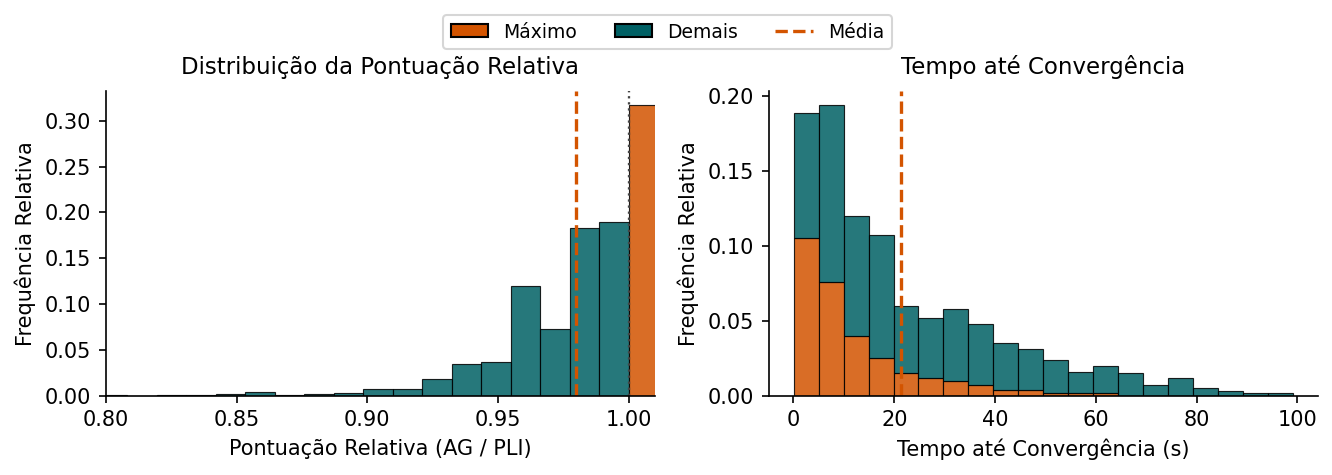

In [64]:
plt.style.use("default")
fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(9, 3), dpi=150)

# --- Esquerda: histograma da pontuação relativa (frequência relativa) ---
vals_sem_1 = df_resumo[df_resumo['pontuacao_relativa'] < 1]['pontuacao_relativa']
num_1 = len(df_resumo[df_resumo['pontuacao_relativa'] == 1])
n_bins_calc = min(18, max(8, int(np.sqrt(len(vals_sem_1)))))

bins = np.linspace(vals_sem_1.min(), 1.0, n_bins_calc + 1)
largura_bin = bins[1] - bins[0]

weights_sem_1 = np.ones_like(vals_sem_1, dtype=float) / len(df_resumo)
weight_ones   = num_1 / len(df_resumo)

ax_left.hist(vals_sem_1, bins=bins, weights=weights_sem_1,
             color=cor1, edgecolor="black", linewidth=0.55, alpha=0.85)
ax_left.bar(1.0, weight_ones, width=largura_bin, align='edge',
            color=cor2, edgecolor="black", linewidth=0.55, alpha=0.85)

media_pr = df_resumo['pontuacao_relativa'].mean()
ax_left.axvline(media_pr, color=cor2, lw=1.6, linestyle="--")
ax_left.axvline(1.0, color="#444444", lw=1.1, linestyle=":")

ax_left.set_title("Distribuição da Pontuação Relativa", fontsize=11, pad=8)
ax_left.set_xlabel("Pontuação Relativa (AG / PLI)", fontsize=10)
ax_left.set_ylabel("Frequência Relativa", fontsize=10)
ax_left.set_xlim(0.8, 1.01)
ax_left.set_facecolor("white")
for s in ['top','right']:
    ax_left.spines[s].set_visible(False)
ax_left.grid(False)

# --- Direita: histograma empilhado do tempo até convergência (frequência relativa; convergidos por baixo) ---
mask_max = df_resumo['fit_max']
tempos_convergiu = df_resumo.loc[mask_max, 'tempo_ate_convergencia']
tempos_nao       = df_resumo.loc[~mask_max, 'tempo_ate_convergencia']

n_bins_tempo = 20
tempo_min = df_resumo['tempo_ate_convergencia'].min()
tempo_max = df_resumo['tempo_ate_convergencia'].max()
bins_tempo = np.linspace(tempo_min, tempo_max, n_bins_tempo + 1)

weights_convergiu = np.ones(len(tempos_convergiu), dtype=float) / len(df_resumo)
weights_nao       = np.ones(len(tempos_nao), dtype=float) / len(df_resumo)

ax_right.hist([tempos_convergiu, tempos_nao],
              bins=bins_tempo,
              weights=[weights_convergiu, weights_nao],
              stacked=True,
              color=[cor2, cor1],
              edgecolor="black",
              linewidth=0.55,
              alpha=0.85)

media_tempo = df_resumo['tempo_ate_convergencia'].mean()
ax_right.axvline(media_tempo, color=cor2, lw=1.6, linestyle="--")

ax_right.set_title("Tempo até Convergência", fontsize=11, pad=8)
ax_right.set_xlabel("Tempo até Convergência (s)", fontsize=10)
ax_right.set_ylabel("Frequência Relativa", fontsize=10)
ax_right.set_facecolor("white")
for s in ['top','right']:
    ax_right.spines[s].set_visible(False)
ax_right.grid(False)

# Legenda única acima
legend_handles = [
    Patch(facecolor=cor2, edgecolor='black', label='Máximo'),
    Patch(facecolor=cor1, edgecolor='black', label='Demais'),
    Line2D([0], [0], color=cor2, lw=1.6, linestyle="--", label=f"Média"),
]
fig.legend(handles=legend_handles, loc='upper center', ncol=4, frameon=True,
           fontsize=9, bbox_to_anchor=(0.5, 1.06))

plt.tight_layout()
plt.savefig("../graficos/ag_duplo_hist_pontuacao_e_tempo_convergencia_freq_relativa.pdf",
            format="pdf", bbox_inches="tight")
plt.show()
# ...existing code...

In [73]:
df_resumo['pontuacao_relativa'].quantile([.1,.15,.2, 0.25, 0.5, 0.75])

0.10    0.948868
0.15    0.956522
0.20    0.963235
0.25    0.970588
0.50    0.992424
0.75    1.000000
Name: pontuacao_relativa, dtype: float64

In [75]:
len(df_resumo[df_resumo['pontuacao_relativa'] > .99])

506

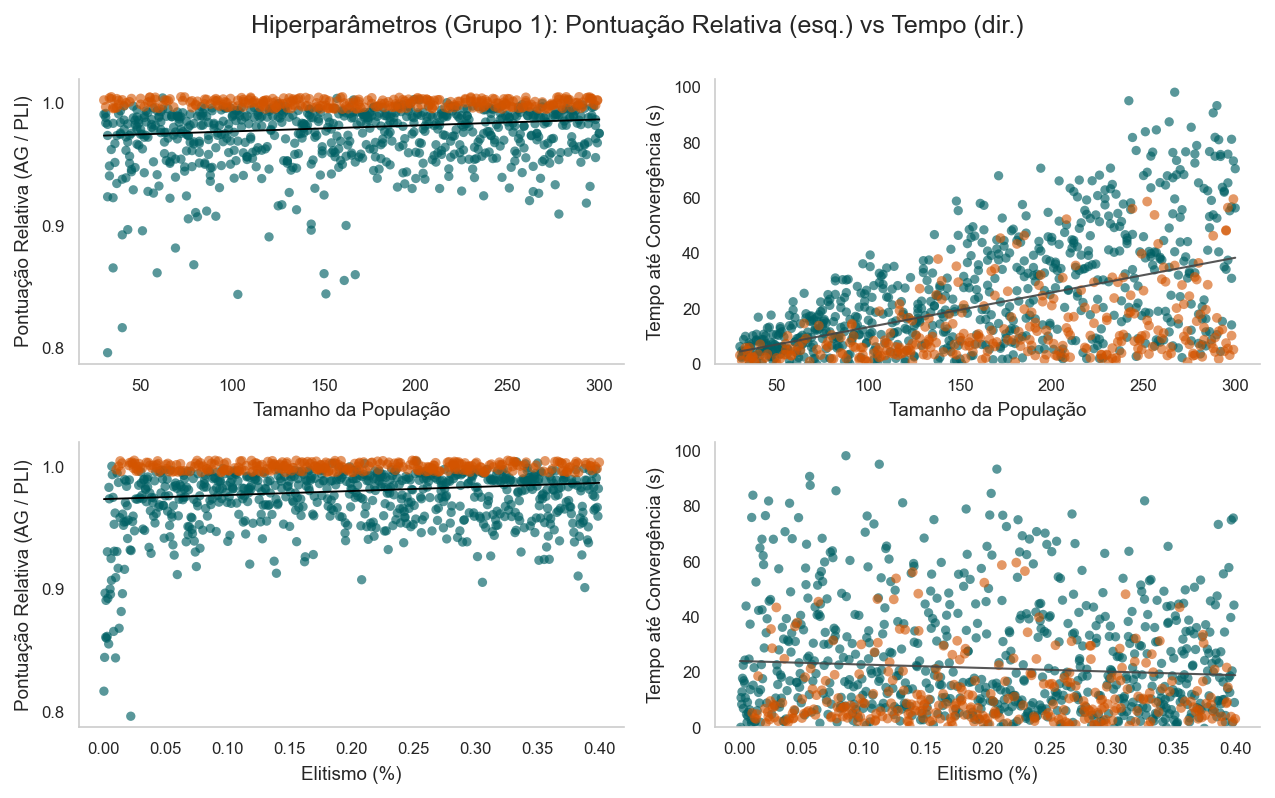

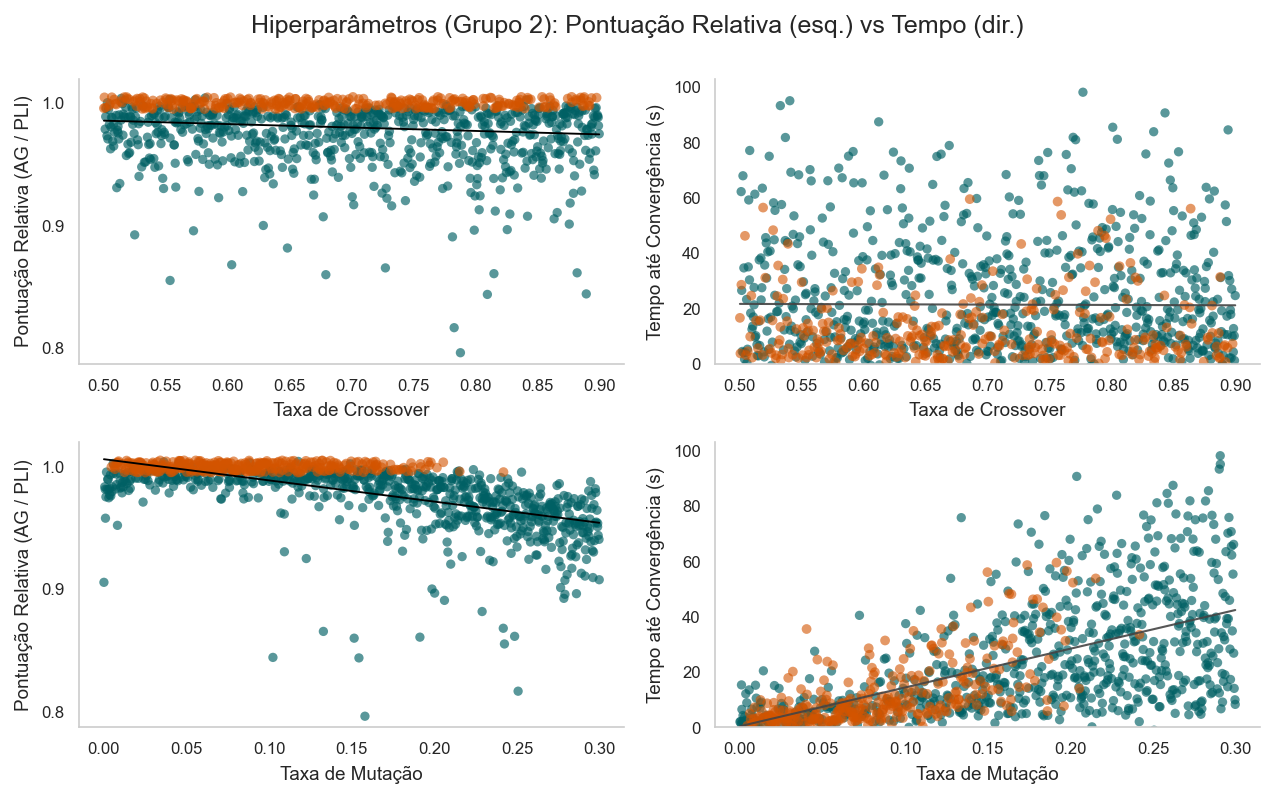

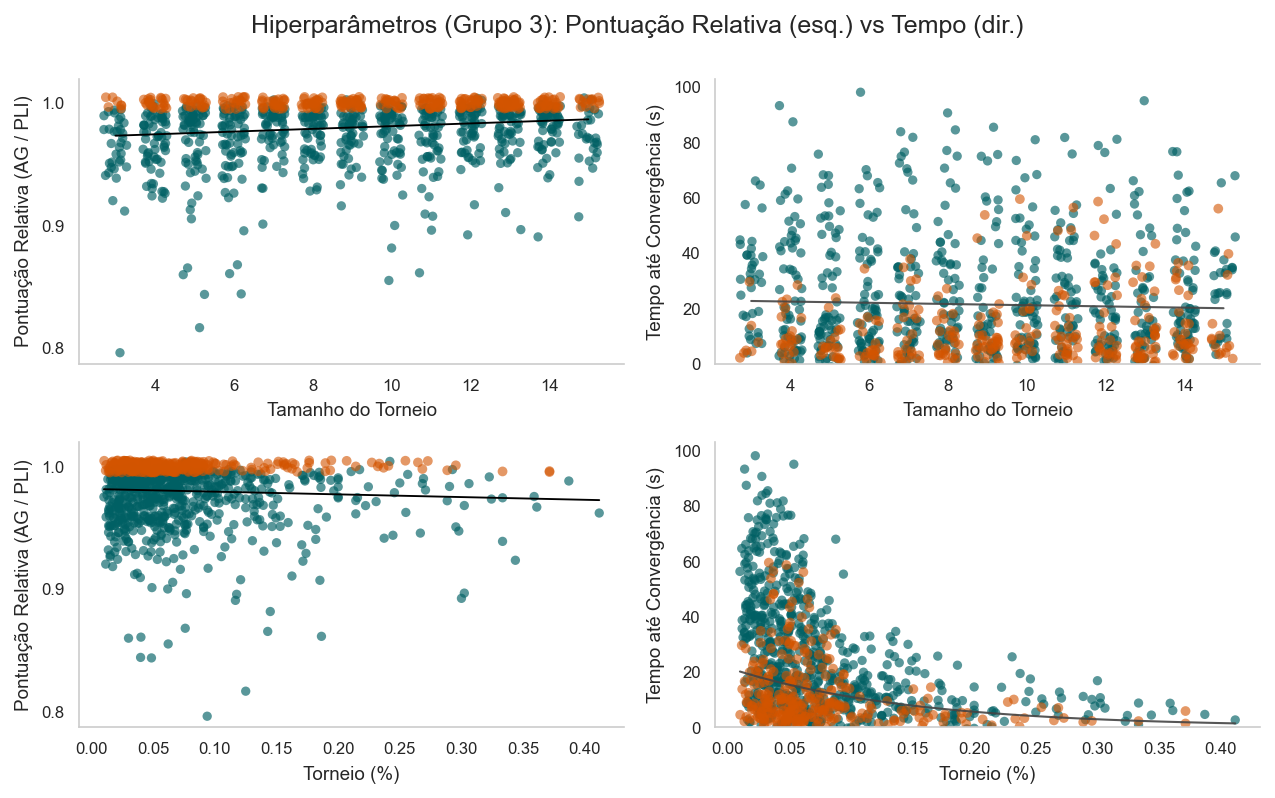

In [76]:
plot_cfg = {
    "sizes":      {"sucesso": 22, "falha": 20},
    "alphas":     {"sucesso": 0.6, "falha": .65},
    "edgecolors": {"sucesso": "none", "falha": "none"},   # use 'black' ou '#333' se quiser borda
    "edgewidth":  0.6,                                    # linewidth da borda
    "jitter": {
        "x_amplitude_small": 0.25,   # jitter horizontal se poucas categorias únicas
        "y_rel": 0.005,              # amplitude do jitter vertical para pontuação_relativa
        "y_tempo_factor": 0.015      # fator * range do tempo para jitter vertical
    },
    "seed": 42
}

pares_figuras = [
    ["n_populacao", "elit_pct"],
    ["taxa_crossover", "taxa_mutacao"],
    ["tamanho_torneio", "torneio_pct"]
]

# Rótulos customizáveis para eixo X (edite conforme desejar)
x_labels = {
    "n_populacao": "Tamanho da População",
    "elit_pct": "Elitismo (%)",
    "taxa_crossover": "Taxa de Crossover",
    "taxa_mutacao": "Taxa de Mutação",
    "tamanho_torneio": "Tamanho do Torneio",
    "torneio_pct": "Torneio (%)"
}

# Cores conforme novo arquivo
sucesso_color = cor2      # pontuação_relativa == 1.0
falha_color   = cor1      # pontuação_relativa  < 1.0
edgecol = "#000000"
alpha_sucesso = 0.6
alpha_falha = 0.5
rng = np.random.default_rng(42)

def jitter_vals(series, amplitude=0.30):
    arr = series.astype(float).copy()
    if series.nunique() <= 15:
        arr += rng.uniform(-amplitude, amplitude, size=len(arr))
    return arr

mask_sucesso = (df_resumo["fit_max"])
y_rel = df_resumo["pontuacao_relativa"]
y_min = max(0.75, y_rel.min() - 0.01)
y_max = 1.02
tempo_raw = df_resumo["tempo_ate_convergencia"].astype(float)

y_rel_jitter = y_rel + rng.uniform(-plot_cfg["jitter"]["y_rel"],
                                   plot_cfg["jitter"]["y_rel"],
                                   size=len(y_rel))
tempo_range = max(1e-9, tempo_raw.max() - tempo_raw.min())
tempo_jitter = tempo_raw + rng.uniform(-plot_cfg["jitter"]["y_tempo_factor"] * tempo_range,
                                       plot_cfg["jitter"]["y_tempo_factor"] * tempo_range,
                                       size=len(tempo_raw))

for grupo_idx, grupo in enumerate(pares_figuras, start=1):
    n_rows = len(grupo)
    fig, axes = plt.subplots(n_rows, 2, figsize=(8.6, 2.65 * n_rows), dpi=150)
    if n_rows == 1:
        axes = np.array([axes])

    for i, hp in enumerate(grupo):
        ax_left  = axes[i, 0]
        ax_right = axes[i, 1]

        # --- ESQUERDA: Pontuação Relativa vs parâmetro ---
        x_raw_l = df_resumo[hp].astype(float)
        x_plot_l = jitter_vals(x_raw_l) if x_raw_l.nunique() <= 15 else x_raw_l

        # --- ESQUERDA: Pontuação Relativa ---
        ax_left.scatter(
            x_plot_l[~mask_sucesso], y_rel_jitter[~mask_sucesso],
            s=plot_cfg["sizes"]["falha"],
            facecolor=cor1,
            edgecolor=plot_cfg["edgecolors"]["falha"],
            linewidth=plot_cfg["edgewidth"],
            alpha=plot_cfg["alphas"]["falha"]
        )
        ax_left.scatter(
            x_plot_l[mask_sucesso], y_rel_jitter[mask_sucesso],
            s=plot_cfg["sizes"]["sucesso"],
            facecolor=cor2,
            edgecolor=plot_cfg["edgecolors"]["sucesso"],
            linewidth=plot_cfg["edgewidth"],
            alpha=plot_cfg["alphas"]["sucesso"]
        )

        # Ajuste linear opcional para pontuação relativa (mantém estilo atual)
        if x_raw_l.nunique() > 1:
            try:
                aa, bb = np.polyfit(x_raw_l, y_rel, 1)
                xx_line = np.linspace(x_raw_l.min(), x_raw_l.max(), 120)
                ax_left.plot(xx_line, aa * xx_line + bb, color="#000000", lw=0.9, alpha=1)
            except Exception:
                pass

        ax_left.set_xlabel(x_labels.get(hp, hp.replace("_", " ").title()), fontsize=9)
        ax_left.set_ylabel("Pontuação Relativa (AG / PLI)", fontsize=9)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_yticks([0.8, 0.9, 1.0])
        ax_left.tick_params(axis="both", labelsize=8)
        ax_left.set_facecolor("white")
        for s in ["top", "right"]:
            ax_left.spines[s].set_visible(False)
        ax_left.grid(False)

        # --- DIREITA: Tempo até convergência vs parâmetro ---
        x_raw_r = df_resumo[hp].astype(float)
        x_plot_r = jitter_vals(x_raw_r) if x_raw_r.nunique() <= 15 else x_raw_r


        # --- DIREITA: Tempo até Convergência ---
        ax_right.scatter(
            x_plot_r[~mask_sucesso], tempo_jitter[~mask_sucesso],
            s=plot_cfg["sizes"]["falha"],
            facecolor=cor1,
            edgecolor=plot_cfg["edgecolors"]["falha"],
            linewidth=plot_cfg["edgewidth"],
            alpha=plot_cfg["alphas"]["falha"]
        )
        ax_right.scatter(
            x_plot_r[mask_sucesso], tempo_jitter[mask_sucesso],
            s=plot_cfg["sizes"]["sucesso"],
            facecolor=cor2,
            edgecolor=plot_cfg["edgecolors"]["sucesso"],
            linewidth=plot_cfg["edgewidth"],
            alpha=plot_cfg["alphas"]["sucesso"]
        )


        # Linhas de tendência:
        # - Padrão: regressão linear
        # - Especial: para 'torneio_pct' usar decaimento exponencial (y = A * exp(-k x) + C) com ajuste por mínimos quadrados no log
        if x_raw_r.nunique() > 1:
            try:
                if hp == "torneio_pct":
                    # Evita zeros/negativos e outliers no log
                    y_t = df_resumo["tempo_ate_convergencia"].astype(float).clip(lower=1e-6)
                    x_t = x_raw_r.astype(float)

                    # Ajuste exponencial simples: lineariza log(y - C). Aqui, C ~ y_min observado
                    C_guess = max(0.0, y_t.min() * 0.8)
                    y_adj = (y_t - C_guess).clip(lower=1e-6)

                    a_log, b_log = np.polyfit(x_t, np.log(y_adj), 1)
                    k = -a_log
                    A = np.exp(b_log)

                    x_line = np.linspace(x_t.min(), x_t.max(), 120)
                    y_fit = A * np.exp(-k * x_line) + C_guess
                    ax_right.plot(x_line, y_fit, color="#444444", lw=1.0, alpha=0.9)
                else:
                    a, b = np.polyfit(x_raw_r, df_resumo["tempo_ate_convergencia"], 1)
                    x_line = np.linspace(x_raw_r.min(), x_raw_r.max(), 120)
                    ax_right.plot(x_line, a * x_line + b, color="#444444", lw=1.0, alpha=0.9)
            except Exception:
                pass

        ax_right.set_xlabel(x_labels.get(hp, hp.replace("_", " ").title()), fontsize=9)
        ax_right.set_ylabel("Tempo até Convergência (s)", fontsize=9)
        ax_right.tick_params(axis="both", labelsize=8)
        ax_right.set_facecolor("white")
        ax_right.set_ylim(bottom=0)  # limite inferior fixo em 0
        for s in ["top", "right"]:
            ax_right.spines[s].set_visible(False)
        ax_right.grid(False)

    fig.suptitle(f"Hiperparâmetros (Grupo {grupo_idx}): Pontuação Relativa (esq.) vs Tempo (dir.)",
                 fontsize=12, y=0.995)
    plt.tight_layout()
    plt.savefig(f"../graficos/ag_hipers_pontuacao_vs_tempo_grupo_{grupo_idx}.pdf",
                 format="pdf", bbox_inches="tight")
    plt.show()
# ...existing code...

In [16]:
p1 = df_resumo[df_resumo['taxa_mutacao'] > .2].copy()
print(p1['pontuacao_relativa'].describe())
print(p1['tempo_ate_convergencia'].describe())
print(p1['fit_max'].value_counts())

count    333.000000
mean       0.958888
std        0.024296
min        0.820144
25%        0.948905
50%        0.963235
75%        0.971631
max        1.000000
Name: pontuacao_relativa, dtype: float64
count    333.000000
mean      35.114890
std       21.811938
min        0.042455
25%       16.871250
50%       31.674866
75%       49.538036
max       99.105268
Name: tempo_ate_convergencia, dtype: float64
fit_max
False    329
True       4
Name: count, dtype: int64


In [21]:
d1 = pd.DataFrame(df_resumo['geracao_convergencia_ag'].value_counts(normalize=True)).reset_index().sort_values('geracao_convergencia_ag')
d1['freq_acumulada'] = d1['proportion'].cumsum()


d1[d1['freq_acumulada']>.8].head(100)

,geracao_convergencia_ag,proportion,freq_acumulada
17,299,0.006,0.803
8,300,0.007,0.810
38,301,0.005,0.815
168,302,0.003,0.818
18,303,0.006,0.824
85,304,0.004,0.828
109,305,0.004,0.832
21,306,0.006,0.838
229,307,0.002,0.840
3,308,0.008,0.848


In [17]:
df_resumo['fit_max'].value_counts()

fit_max
False    696
True     304
Name: count, dtype: int64

In [18]:
329/696

0.47270114942528735